Test compositional lotka volterra algorithm on human gut time series (female test person).

In [3]:
# import sys
# !{sys.executable} -m pip install scipy

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import torch
from scipy.io import loadmat

from scipy.special import logsumexp
from scipy.stats import pearsonr
from scipy.stats import norm

from compositional_lotka_volterra import *

In [5]:
Y = pkl.load(open("data/bucci/Y_cdiff-denoised.pkl", "rb"))
U = pkl.load(open("data/bucci/U_cdiff.pkl", "rb"))
T = pkl.load(open("data/bucci/T_cdiff.pkl", "rb"))

In [6]:
filepath = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/data/"

names_all = []
for sub in np.arange(5):
    # path of data file
    filename_tmp = f"ts_bucci_subject_{sub+1}_rel_counts_most_abundant.csv"
    data = pd.read_csv(f"{filepath}{filename_tmp}", sep=",", header=0)
    names = list(data.columns)[1:]
    names_all.append(names)

In [7]:
# set dimensions of the dataset
n_samples, n_taxa = Y[0].shape

n_subjects = 5

In [8]:
def adjust_concentrations(Y):
    con =  []
    for y in Y:
        con += y.sum(axis=1).tolist()
    con = np.array(con)
    C = 1 / np.mean(con)

    Y_adjusted = []
    for y in Y:
        Y_adjusted.append(C*y)

    return Y_adjusted

In [9]:
Y = adjust_concentrations(Y)

P = []
Y_pc = []
log_Y = []
for y in Y:
    mass = y.sum(axis=1)
    p = y / y.sum(axis=1,keepdims=True)
    p = (p + 1e-5) / (p + 1e-5).sum(axis=1,keepdims=True)
    P.append(p)
    Y_pc.append((mass.T*p.T).T)
    log_Y.append(np.log(mass.T*p.T).T)

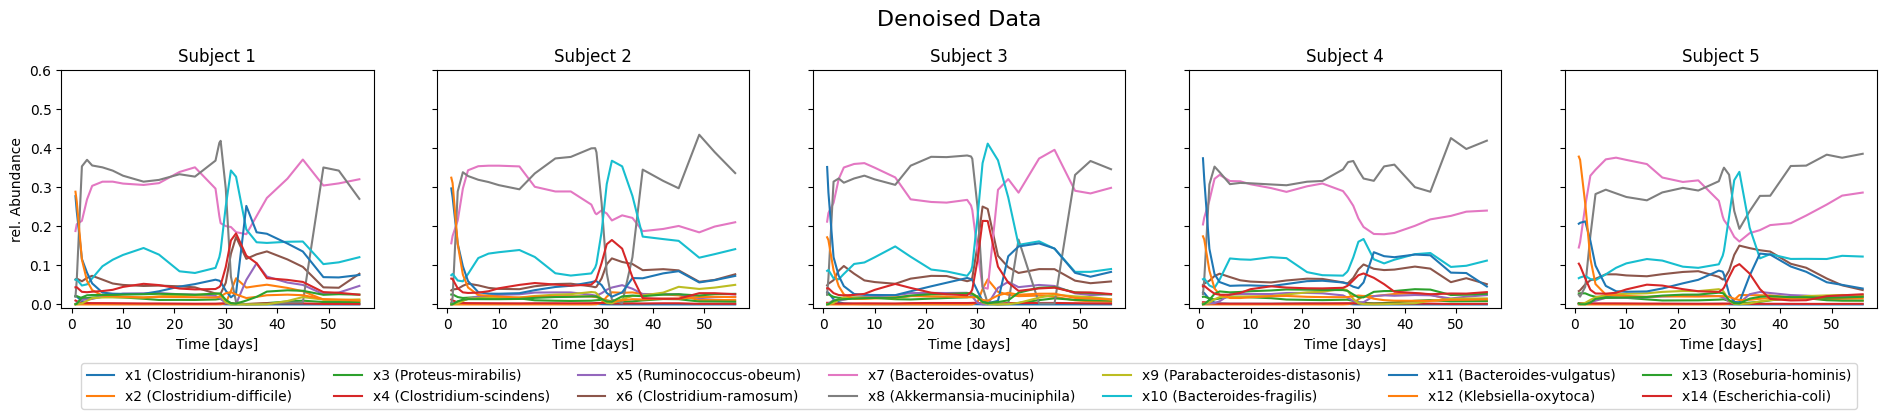

In [41]:
# plot P for all subjects
fig, axs = plt.subplots(1, n_subjects)
fig.set_figwidth(19)
fig.set_figheight(3.5)
fig.suptitle("Denoised Data",
             size = 16)
fig.tight_layout(pad=1.5)
for sub in np.arange(n_subjects):
    for i in np.arange(n_taxa):
        axs[sub].plot(T[sub], P[sub][:,i], label = f"x{i+1} ({names_all[sub][i]})")
    # ax[sub].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[sub].set_title(f"Subject {sub+1}")

for ax in axs.flat:
    ax.set_ylim(-0.01, 0.6)
    ax.set_xlabel("Time [days]")
    ax.set_ylabel("rel. Abundance")
    ax.label_outer()

# axs[sub].legend(loc='center left', bbox_to_anchor=(1, 0.5), title = "Species")
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
              fancybox=True, shadow=False, ncol=7)
plt.show()
# plt.savefig('../../../Plots/bucci_data_denoised_fiveSubjects_legendBottom.pdf', dpi=300, bbox_inches='tight')
# plt.close()

## Additional Analysis regarding choose_denom and ALR

In [9]:
# denom check (from choose_denom(P))
np.seterr(divide="ignore", invalid="ignore")
vars = []
log_change = None
for p in P:
    s = p.sum(axis=1,keepdims=True)
    s[s==0] = 1
    deltas = np.log( (p/s)[1:] ) - np.log( (p/s)[:-1] )
    if log_change is None:
        log_change = deltas
    else:
        log_change = np.vstack((log_change, deltas))
np.seterr(divide="warn", invalid="warn")
# pick taxon with smallest change in log proportion
min_var = np.inf
ntaxa = log_change.shape[1]
for i in range(ntaxa):
    if not np.all(np.isfinite(log_change[:,i])):
        continue
    var = np.var(log_change[:,i])
    vars.append(var)

In [10]:
choose_denom(P)

5

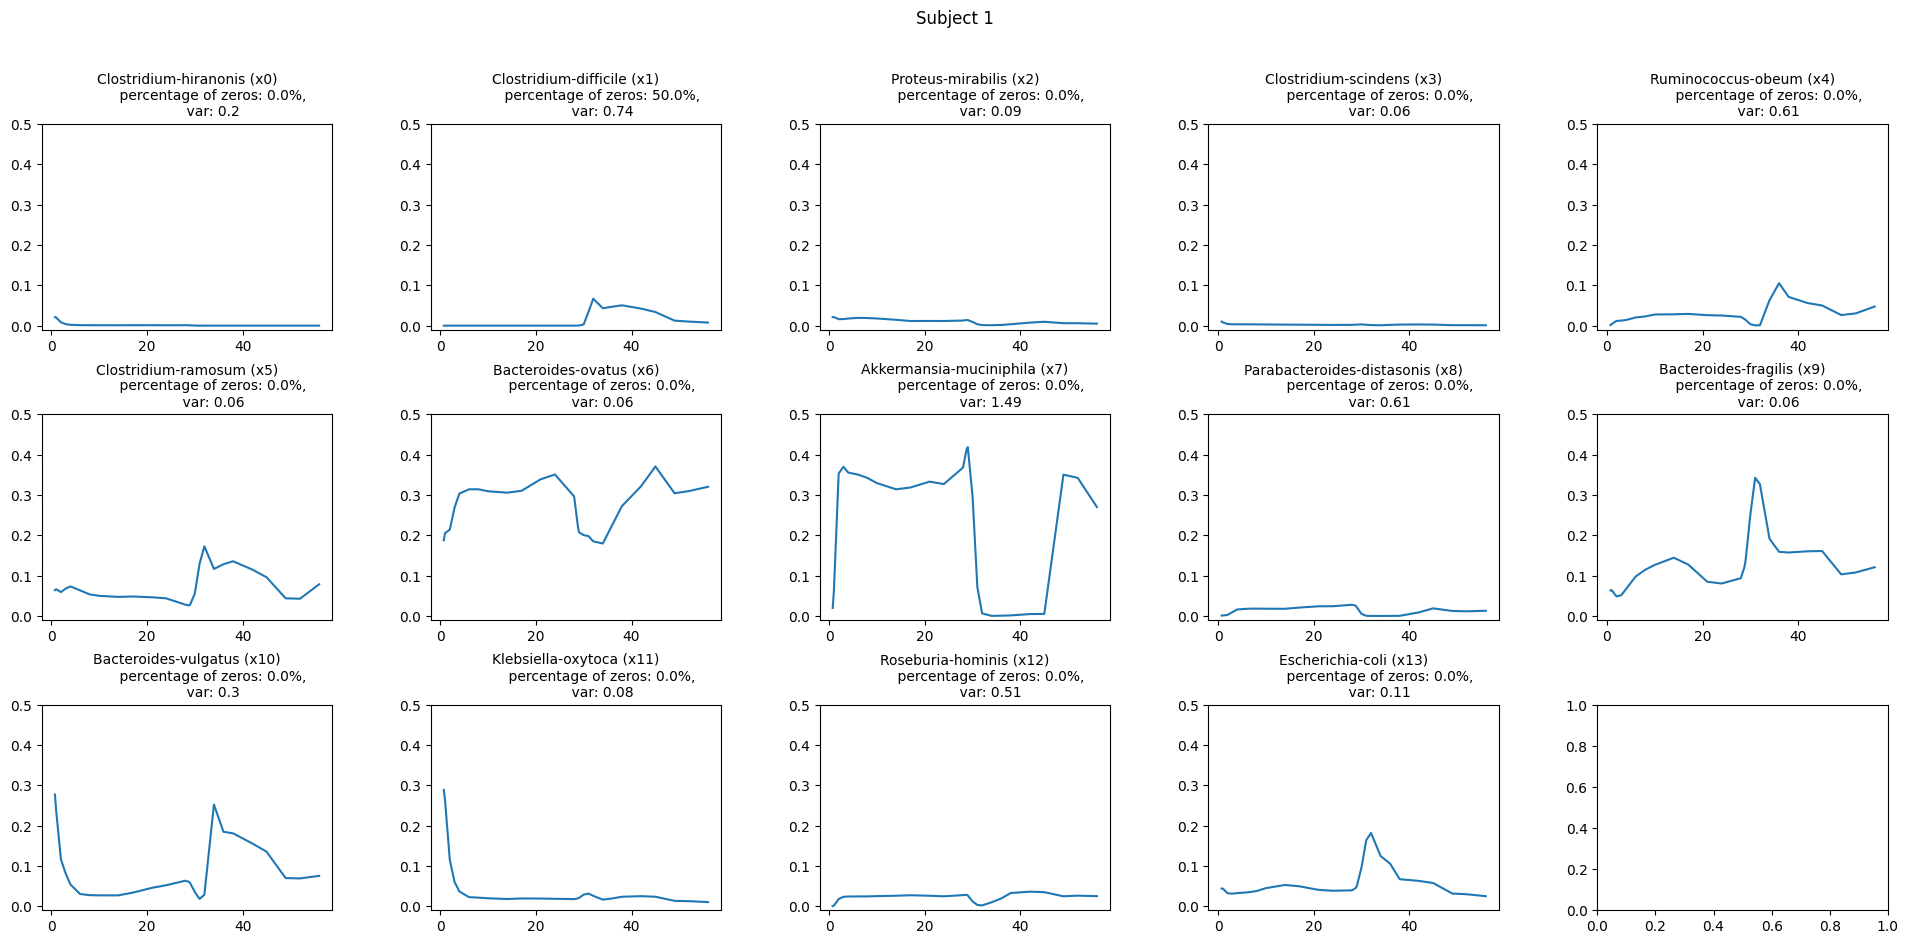

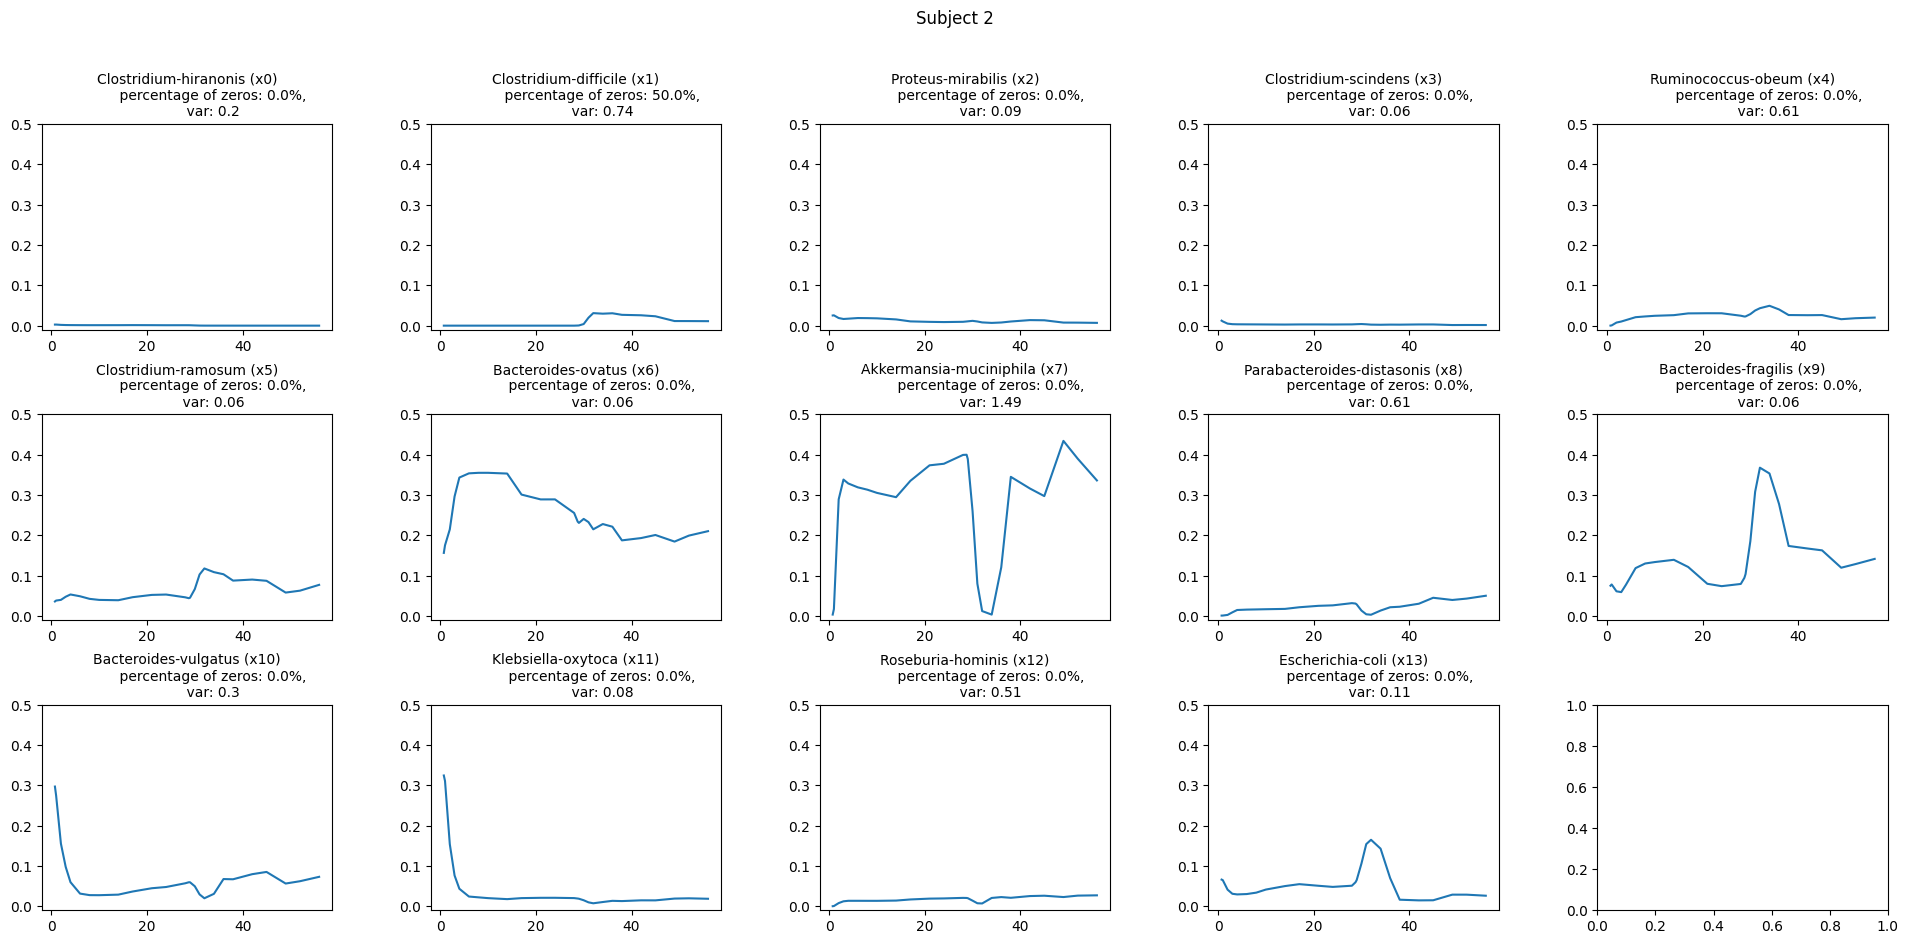

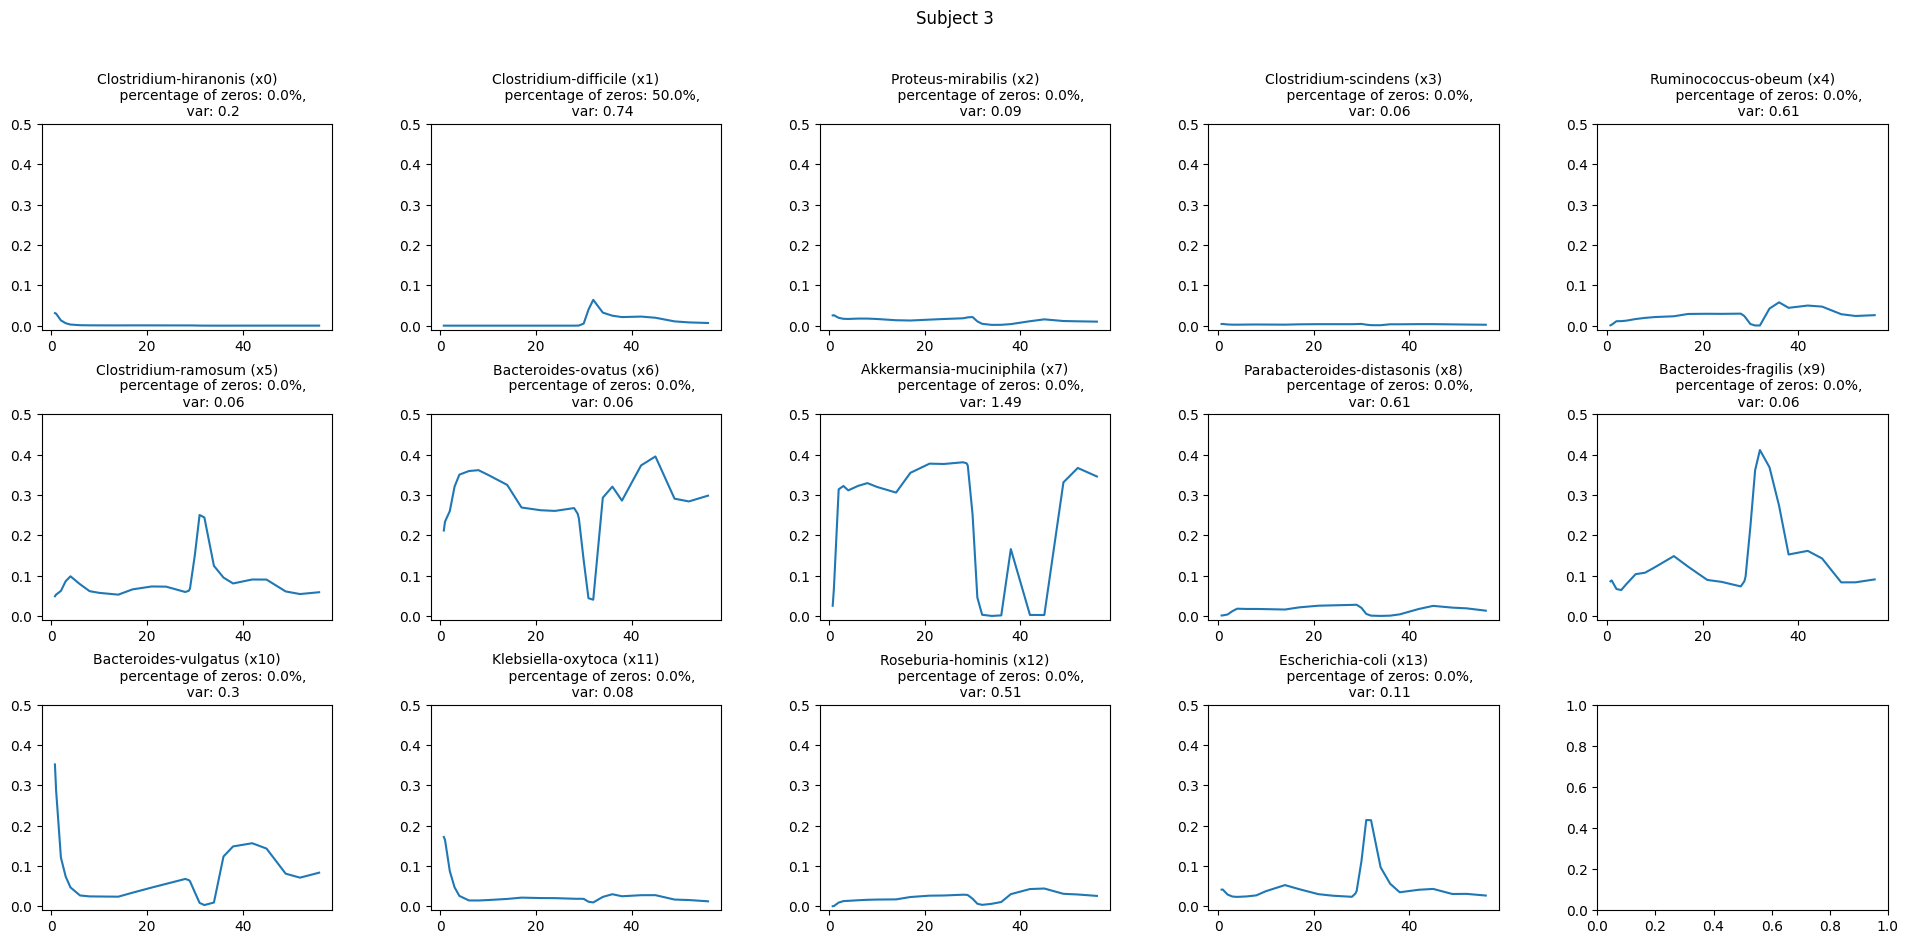

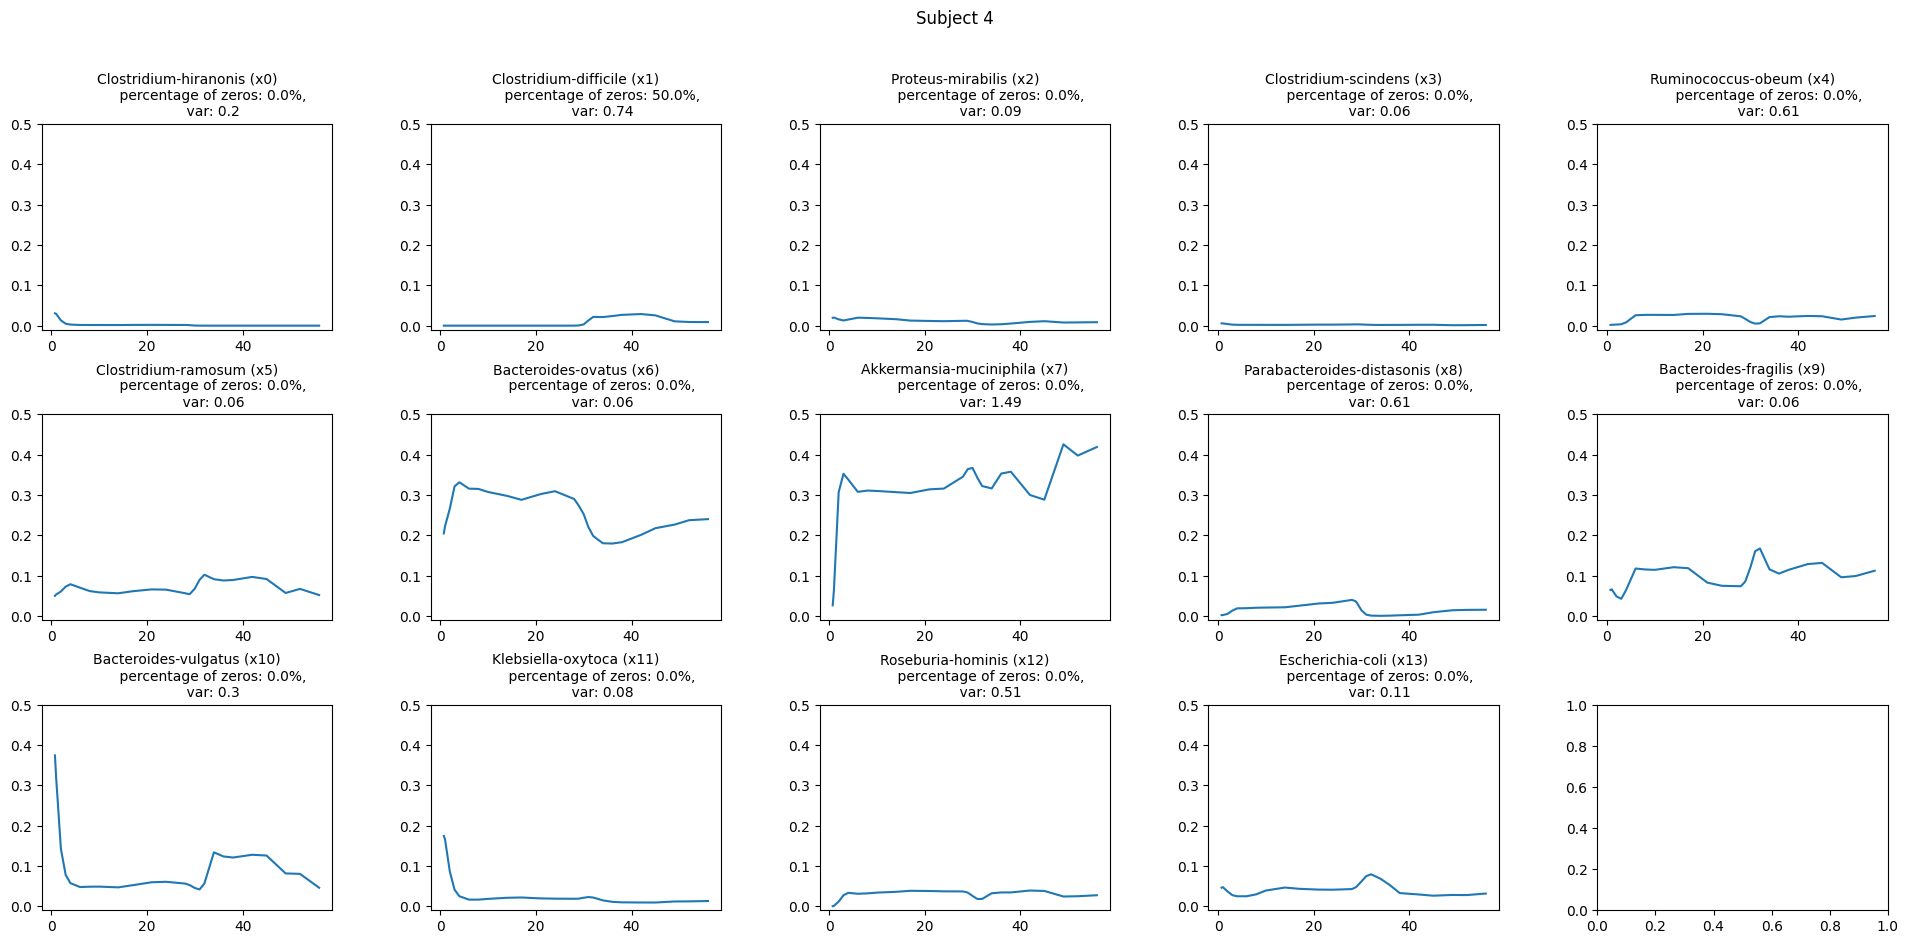

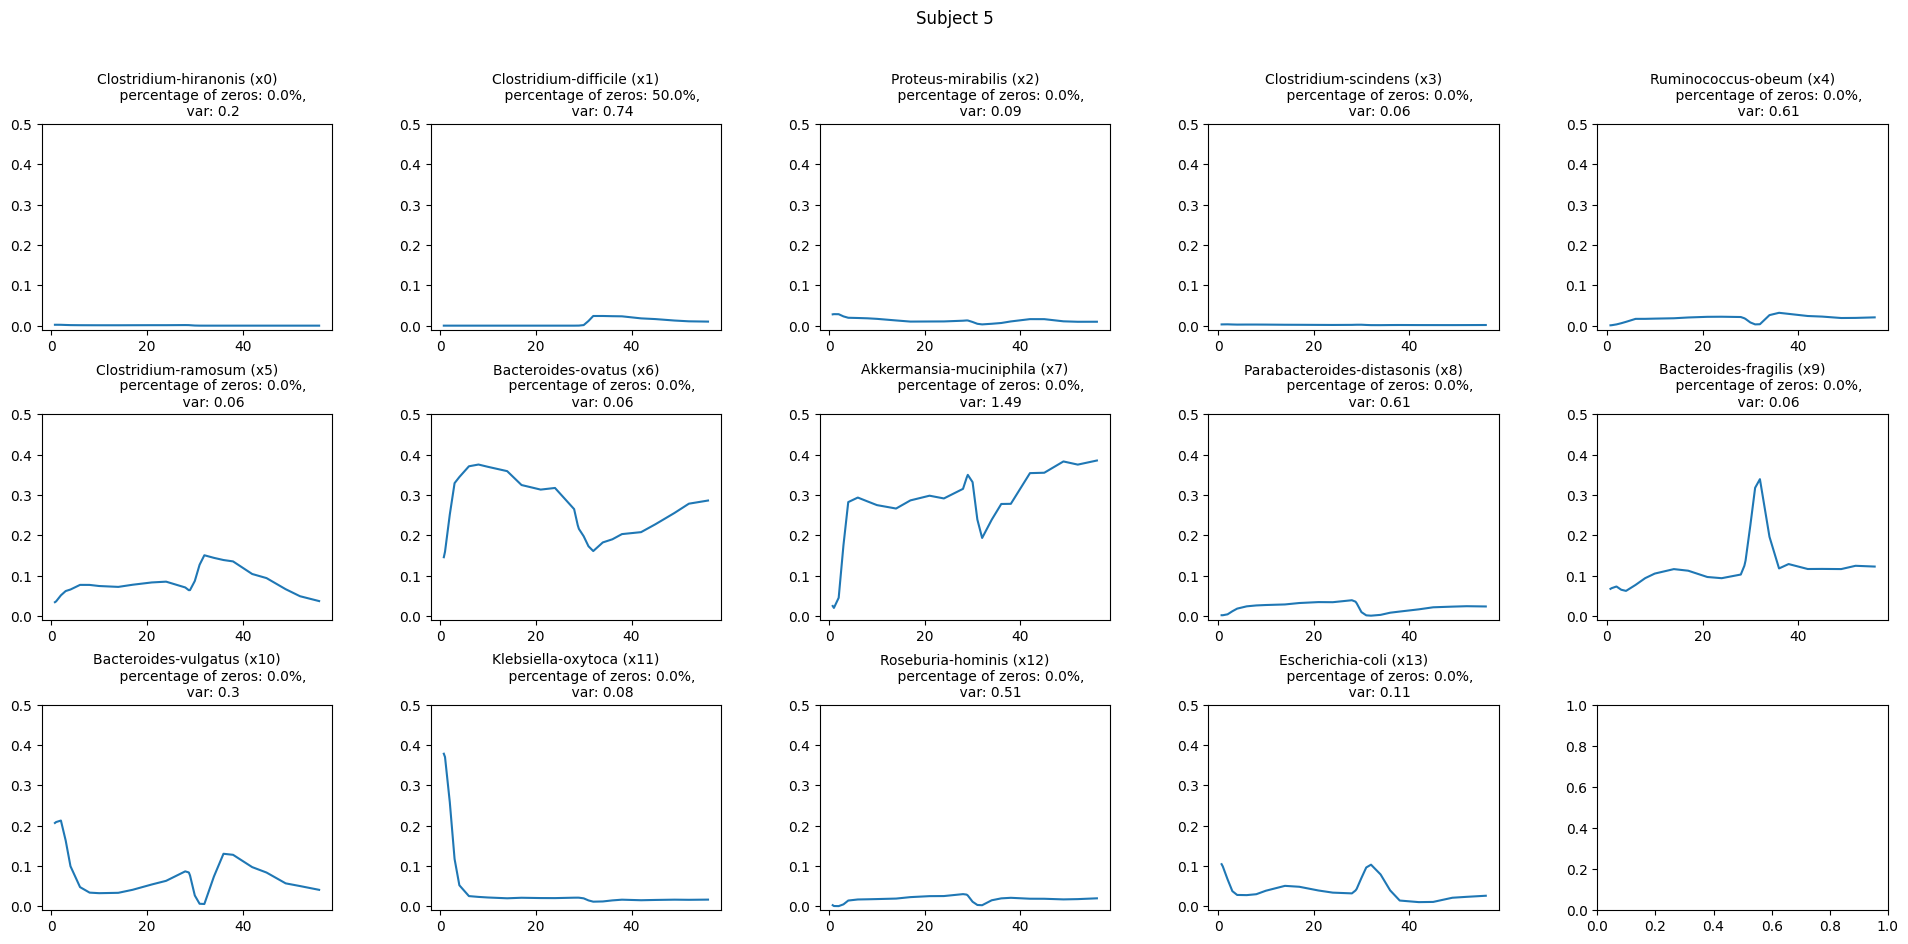

In [11]:
# plot time series with all otus
n_row = 3
n_col = 5
for sub in np.arange(5):
    fig, axs = plt.subplots(n_row, n_col)
    fig.set_figwidth(20)
    fig.set_figheight(10)
    fig.suptitle(f"Subject {sub+1}")
    fig.tight_layout(pad=4.0)
    ind=0
    for i in np.arange(n_taxa):
        # plot each taxon timeline separately
        axs[math.floor(ind/n_col), (ind%n_col)].plot(T[sub], P[sub][:,i])
        axs[math.floor(ind/n_col), (ind%n_col)].set_title(f"""{names_all[sub][i]} (x{i})
            percentage of zeros: {round(sum(Y[sub][:,i] == 0)/n_samples*100, 1)}%,
            var: {round(vars[i],2)}""")
        axs[math.floor(ind/n_col), (ind%n_col)].title.set_size(10)
        axs[math.floor(ind/n_col), (ind%n_col)].set_ylim([-0.01, 0.5])
        ind += 1

### choose final denominator and do alr transformation

In [12]:
# use choose_denom function to select denominator
# denom = choose_denom(P)
denom = 3
print(denom)

ALR = construct_alr(P, denom)

3


In [1]:
for sub in np.arange(n_subjects):
    denom_name = names_all.pop(denom)

NameError: name 'np' is not defined

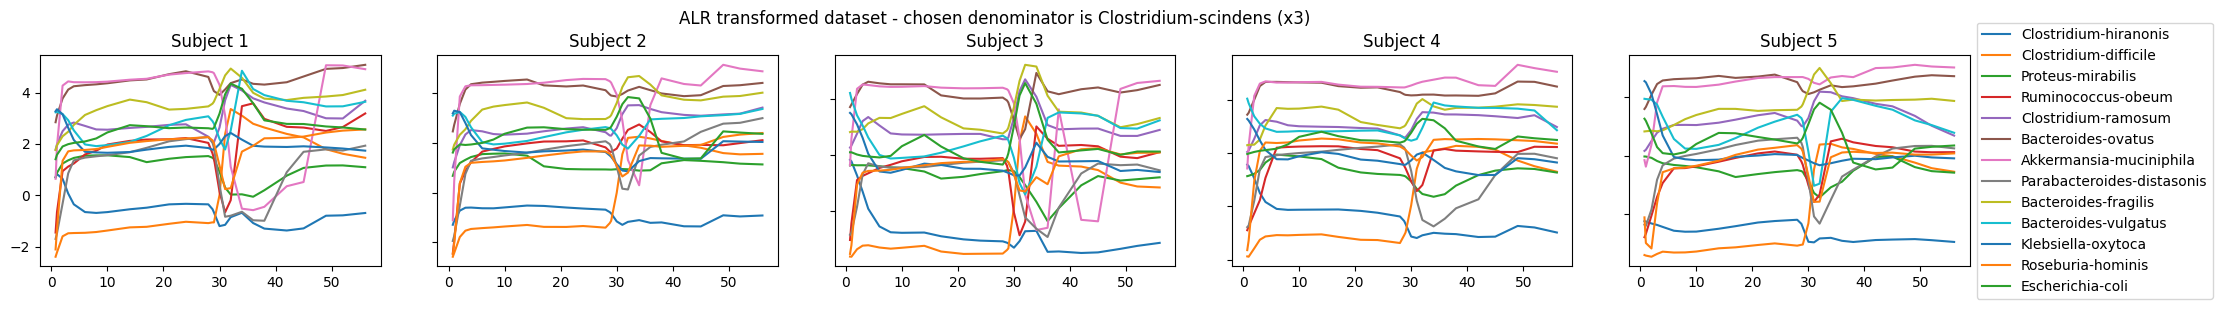

In [14]:
# plot alr transformed time series for all 
fig, axs = plt.subplots(1, n_subjects)
fig.set_figwidth(20)
fig.set_figheight(3)
fig.suptitle(f"ALR transformed dataset - chosen denominator is {denom_name} (x{denom})")
fig.tight_layout(pad=1.0)
for sub in np.arange(n_subjects):
    for i in np.arange(n_taxa-1):
        axs[sub].plot(T[sub], ALR[sub][:,i], label = names_all[sub][i])
    axs[sub].set_title(f"Subject {sub+1}")

for ax in axs.flat:
    ax.label_outer()

axs[sub].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### save ALR as csv file

In [15]:
# save alr as csv file
for sub in np.arange(n_subjects):
    ALR = construct_alr(P, denom)
    df_ALR = pd.DataFrame(ALR[sub])
    df_ALR.insert(0, "Time", T[sub])
    df_ALR.to_csv(f'{filepath}ALR_denom{denom}_ts_bucci_subject_{sub+1}_rel_counts_denoised.csv', index=False)

## CLV Analysis

In [ ]:
# estimated previously
r_A = 0.25
r_g = 4
r_B = 0.125

In [ ]:
clv = CompositionalLotkaVolterra(P, T, U, pseudo_count=1e-5)
clv.r_A = r_A
clv.r_g = r_g
clv.r_B = r_B

In [ ]:
clv.alpha = 1
clv.train()

In [ ]:
estimate_ridge_regularizers_cv(clv.X, clv.P, clv.U, clv.T, clv.denom, folds=10, no_effects=T)
# clv.train_ridge()
# A_clv, g_clv, B_clv = clv.get_params()

# print(A_clv, g_clv, B_clv)